# **1.Conectamos Colab con Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
PATH_ORIGEN = "/content/drive/MyDrive/Proyectos-independientes/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG"
os.chdir(PATH_ORIGEN)

In [4]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py
import utils
import math
from fractions import Fraction
from tqdm.auto import tqdm 
from skimage.feature import greycomatrix, greycoprops
import pandas as pd 
import time
import torch

In [5]:
sys.path.append(os.path.abspath(PATH_ORIGEN))

In [6]:
!nvidia-smi

Thu Nov  4 02:27:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (HGG-LGG)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 155

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

In [8]:
in_dir = "/content/drive/MyDrive/Proyectos-independientes/Proyecto-MINSA/Dataset/Clasificacion/HGG-LGG/AVI"

# **2.Llamando funciones de Utils.py**

In [9]:
names, labels = utils.label_video_names(in_dir)

In [10]:
print(names[0])
print(len(names))

print(labels[0])
print(len(labels))

HGG_Training_057_total.mp4
369
[1, 0]
369


In [11]:
frames = utils.get_frames(in_dir, names[12])
print(frames.shape)

(155, 224, 224, 3)


In [12]:
visible_frame = (frames*255).astype('uint8')

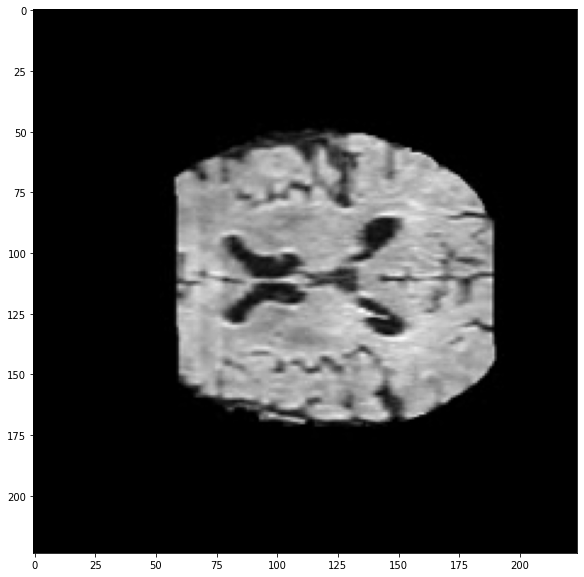

In [13]:
img = visible_frame[80][:,:,2]
plt.figure(1,figsize = (10,10))
plt.imshow(img,cmap = 'gray')
plt.show()

# **2.1.Preprocesamiento** 

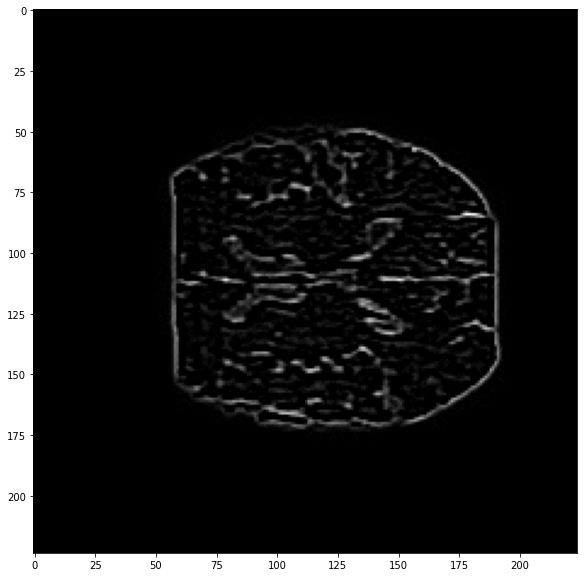

In [14]:
# P1: Filtro LoG 
blur = cv2.GaussianBlur(img,(3,3),0) 
laplacian = cv2.Laplacian(blur,cv2.CV_8UC1)
#laplacian1 = laplacian/laplacian.max()

plt.figure(1,figsize = (10,10))
plt.imshow(laplacian,cmap = 'gray')
plt.show()

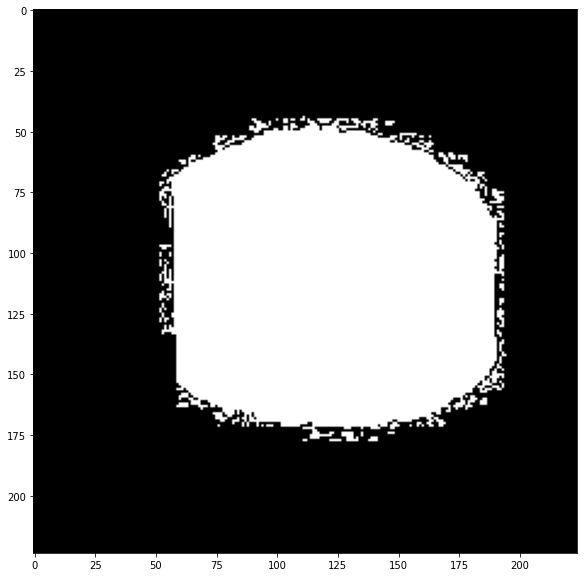

In [16]:
# P2: Umbralizacion
aux = np.zeros((img.shape[0],img.shape[1]),dtype= np.uint8)
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i,j] != 0: 
      aux[i,j] = 1
    else:
      aux[i,j] = 0

plt.figure(1,figsize = (10,10))
plt.imshow(aux,cmap = 'gray')
plt.show()

In [17]:
# Contorno más grande
cnts,_ = cv2.findContours(laplacian,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
#cnts,_ = cv2.findContours(aux,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
contour_sizes = [(cv2.contourArea(cnt), cnt) for cnt in cnts]
biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

In [18]:
# Coordenadas que encierran al contorno más grande 
x,y,w,h = cv2.boundingRect(biggest_contour)
print("Coordenadas: " + " \n x1: " + str(x) ," \n x2:" , str(x + w) , "\n y1: ", str(y) , "\n y2:", str(y + h))

Coordenadas:  
 x1: 50  
 x2: 196 
 y1:  43 
 y2: 179


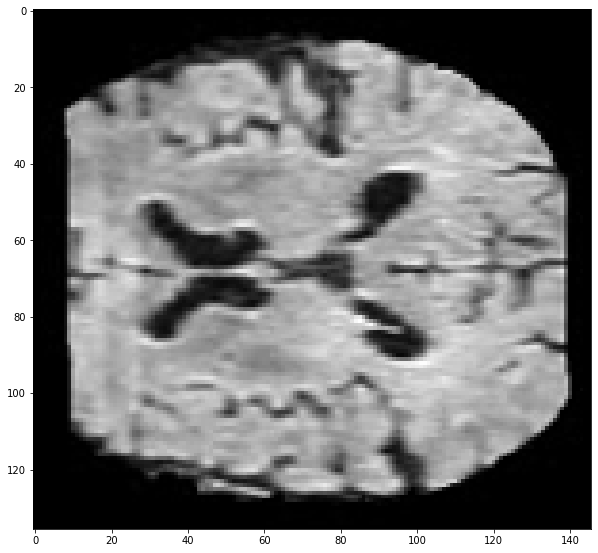

(136, 146)


In [19]:
# Cropped --> LoG
crop = img[y:y+h,x:x+w]
plt.figure(1,figsize = (10,10))
plt.imshow(crop,cmap = "gray")
plt.show()

print(crop.shape)

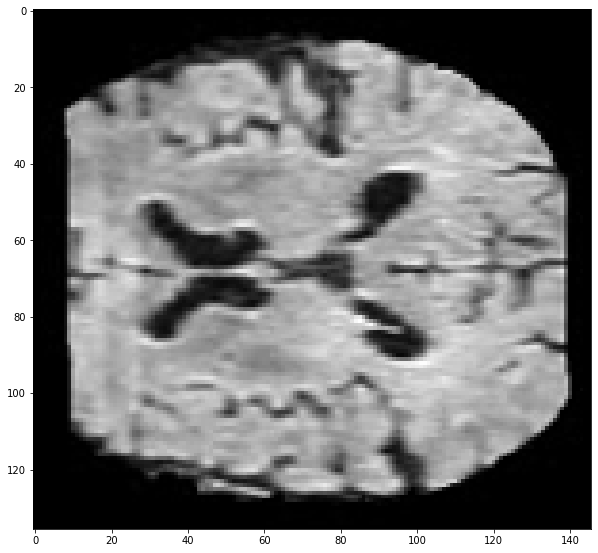

(136, 146)


In [20]:
# Cropped --> Umbralizacion
crop = img[y:y+h,x:x+w]
plt.figure(1,figsize = (10,10))
plt.imshow(crop,cmap = "gray")
plt.show()

print(crop.shape)

In [21]:
def LoG(image):
  blur = cv2.GaussianBlur(image,(3,3),0)
  laplacian = cv2.Laplacian(blur,cv2.CV_8UC1) 

  cnts,_ = cv2.findContours(laplacian,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  contour_sizes = [(cv2.contourArea(cnt), cnt) for cnt in cnts]
  biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

  x,y,w,h = cv2.boundingRect(biggest_contour)
  crop = image[y:y+h,x:x+w]

  return crop

In [22]:
def cropped(image):

  aux = np.zeros((img.shape[0],img.shape[1]),dtype= np.uint8)

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j] != 0: 
        aux[i,j] = 1
      else:
        aux[i,j] = 0
  
  cnts,_ = cv2.findContours(aux,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  contour_sizes = [(cv2.contourArea(cnt), cnt) for cnt in cnts]

  if len(contour_sizes) > 0:
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    x,y,w,h = cv2.boundingRect(biggest_contour)
    crop = image[y:y+h,x:x+w] 

    return crop

In [23]:
len(crop.shape)

2

# **3. Feature Extraction**

## **3.1.Transformada de Gabor**

In [24]:
# Diccionario de parámetros 
thetas = np.arange(0, np.pi, np.pi/4) # range of theta 
lambds = np.array([ 2 * pow(math.sqrt(2), i + 1) for i in range(5)], dtype = 'float32') # range of lambda
sigmas = np.array([1.5,2.5]) # range de desviacion estandar
gamma = 1 
psis = np.array([0,np.pi/2], dtype = 'float32')

In [25]:
## Creacion de banco de gabor
gaborFilterBank0 = []
gaborFilterBank90 = []

gaborParams0 = []
gaborParams90 = []


## Agregando valores al banco de gabor
for theta in thetas:
    for lambd in lambds:
        for sigma in sigmas:
            gaborParam0 = {'ksize':(20, 20),'sigma':sigma,'theta':theta,
                          'lambd':lambd,'gamma':gamma,'psi':0,'ktype':cv2.CV_32F}
            gaborParam90 = {'ksize':(20, 20),'sigma':sigma,'theta':theta,
                          'lambd':lambd,'gamma':gamma,'psi':90,'ktype':cv2.CV_32F}
            
            Gabor0 = cv2.getGaborKernel(**gaborParam0)
            Gabor90 = cv2.getGaborKernel(**gaborParam90)
            
            gaborFilterBank0.append(Gabor0)
            gaborFilterBank90.append(Gabor90)
            
            gaborParams0.append(gaborParam0)
            gaborParams90.append(gaborParam90)

Banco de funciones de Gabor para distintos angulos con psi = 0


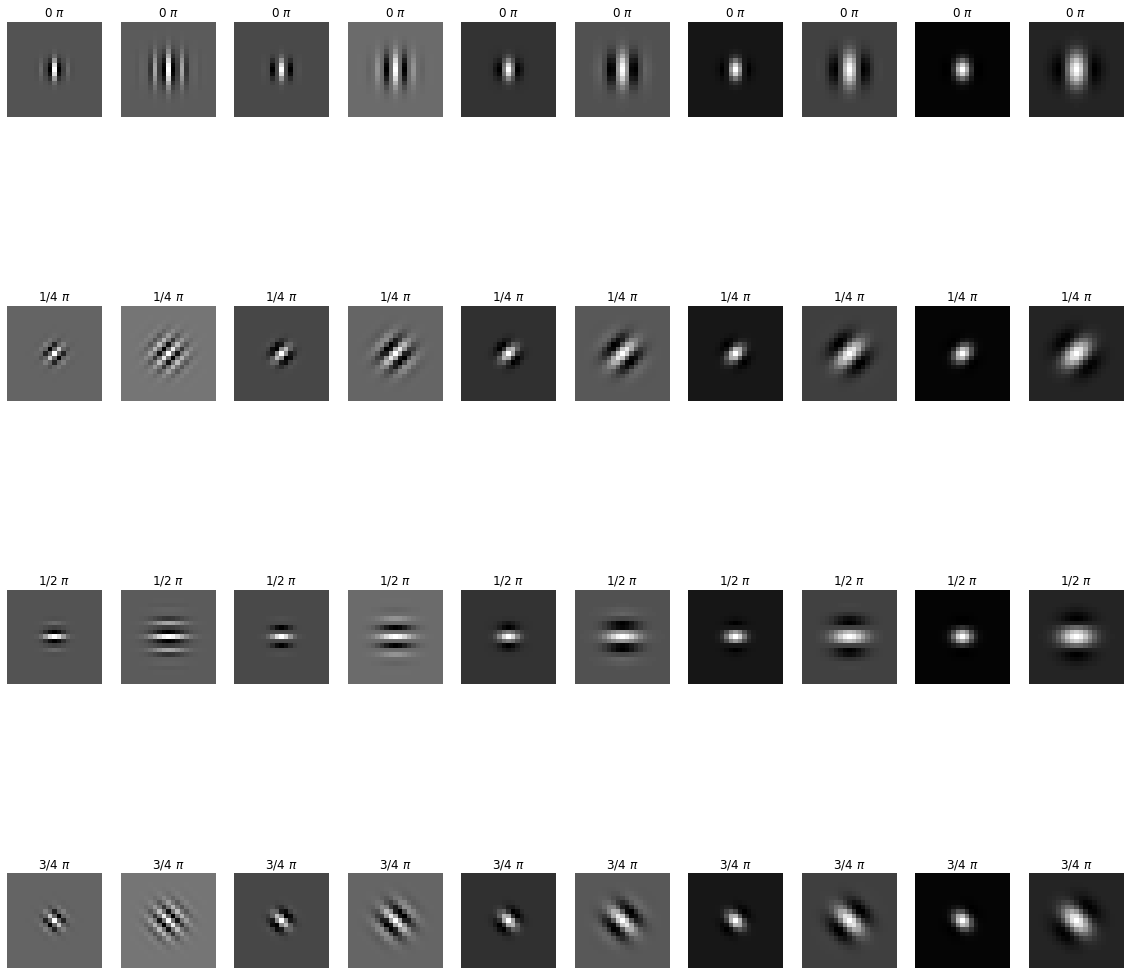

In [26]:
# Plot
print("Banco de funciones de Gabor para distintos angulos con psi = 0")
fig = plt.figure(1,figsize=(20,20))
n0 = len(gaborFilterBank0)
for i in range(n0):
    ang= gaborParams0[i]['theta'] / np.pi
    a = Fraction(ang)
    plt.subplot(4,n0//4, i+1)
    plt.title("{} $\pi$".format(a))
    plt.axis('off')
    plt.imshow(gaborFilterBank0[i],cmap='gray')

plt.show()

Banco de funciones de Gabor para distintos angulos con psi = 90


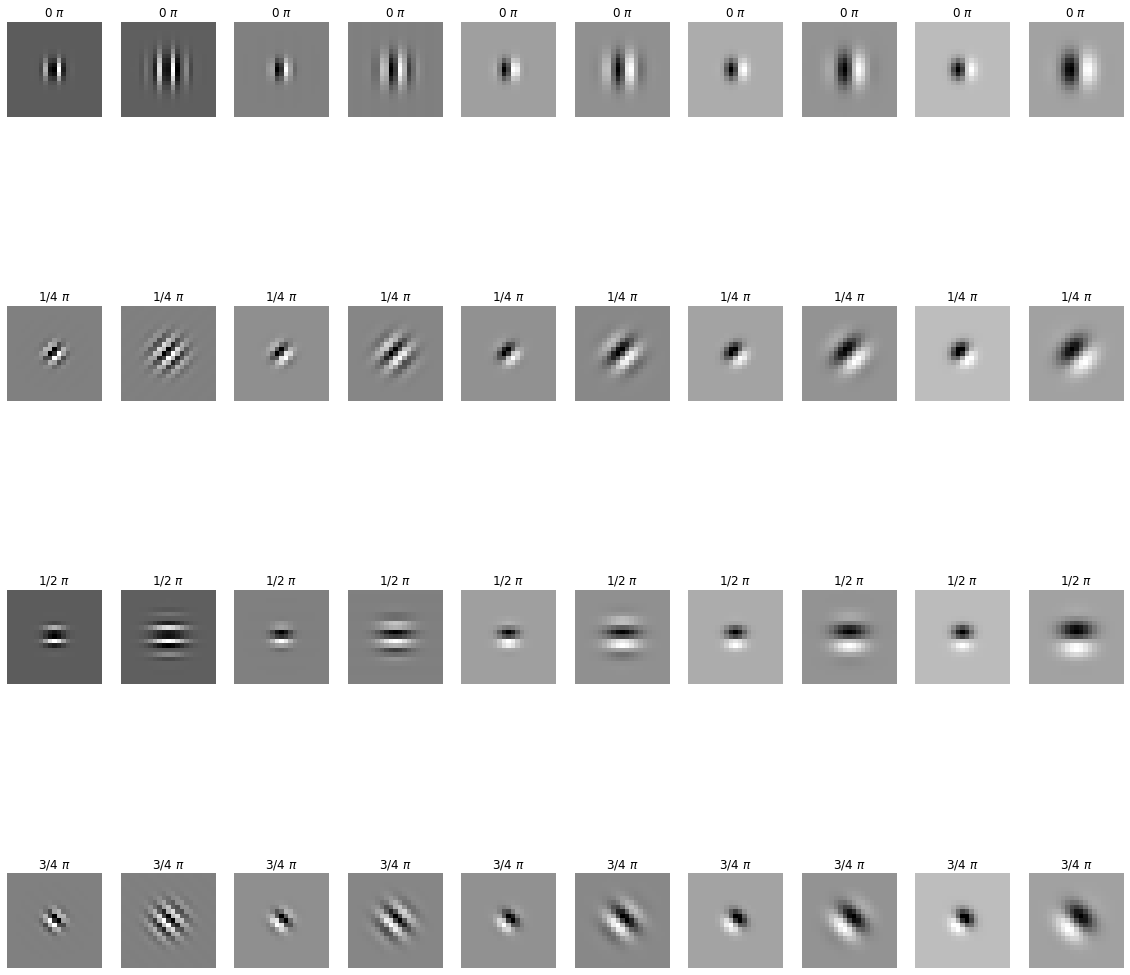

In [27]:
# Plot
print("Banco de funciones de Gabor para distintos angulos con psi = 90")
fig = plt.figure(1,figsize=(20,20))
n90 = len(gaborFilterBank90)
for i in range(n90):
    ang= gaborParams90[i]['theta'] / np.pi
    a = Fraction(ang)
    plt.subplot(4,n90//4, i+1)
    plt.title("{} $\pi$".format(a))
    plt.axis('off')
    plt.imshow(gaborFilterBank90[i],cmap='gray')

plt.show()

In [29]:
def EuclideanDistanceMatrix(M1,M2):
    shape = np.dot(M1,M2.T).shape
    result = np.zeros(shape,dtype = np.float32)
    
    for i in range(M1.shape[0]):
        for j in range(M2.shape[0]):
            a = M1[i,:] # vector fila
            b = M2[j,:] # Vector fila
            dist = np.linalg.norm(a-b)
            #dist = torch.norm(a - b) # escalar
            result[i,j] = dist   
    
    return result

In [30]:
def gabor_features(image,gaborFilterBank0,gaborFilterBank90):
    GaborFeatures = np.zeros((1,40),dtype = np.float32)
    
    for count,(mask0,mask90) in enumerate(zip(gaborFilterBank0,gaborFilterBank90)):

        #count = count + 1
        g0 = cv2.filter2D(image,-1,mask0)
        # convertir a tensor
        #g0_ = torch.from_numpy(g0).float().to(device)
        #g0 = pow(g0,2)

        g90 = cv2.filter2D(image,-1,mask90)
        # convertir a tensor
        #g90_ = torch.from_numpy(g90).float().to(device)
        #g90 = pow(g90,2)

        #g_T = math.sqrt(g0 +  g90)
        
        ### Distancia euclidiana entre 2 matrices 
        g_T = EuclideanDistanceMatrix(g0,g90)

        ### Valor de Gabor 
        suma = np.sum(g_T,axis = 0)
        suma = np.sum(suma)

        GaborFeatures[0,count] = suma  
        #count = count + 1
        
    return GaborFeatures

In [31]:
def glcm_features(image):
  GLCMFeatures = np.zeros((1,6),dtype = np.float32)

  dst = [1] 
  ang = [np.pi/2] # (np.pi/2 --> (dx =0 y dy = dst))

  ## Matriz GLCM nivel 1
  co_matriz_1 = greycomatrix(image, dst, ang).astype('uint8')
  co_matriz_1 = co_matriz_1[:,:,0,0]
  #print("O.o:",co_matriz_1.shape)

  ## Matriz GLCM nivel 2
  co_matriz_2 = greycomatrix(co_matriz_1, dst, ang).astype('uint8')
  #co_matriz_2 = co_matriz_2[:,:,0,0]

  # Indicadores 
  properties = ['ASM', 'correlation','contrast','dissimilarity','energy','homogeneity']

  ## Indicadores 
  """glcm = greycomatrix(co_matriz_2, distances = dst, angles = ang, 
                      symmetric = True,normed = True)"""

  for i,prop in enumerate(properties):
    GLCMFeatures[0,i] =  greycoprops(co_matriz_2, prop)
  
  #print(GLCMFeatures.shape)
  
  #GLCMFeatures[] = np.hstack([greycoprops(co_matriz_2, prop).ravel() for prop in properties])

  return GLCMFeatures

In [ ]:
help(greycoprops)

In [ ]:
!ls

 0.NII-a-Video.ipynb	        inceptionV3
 AVI			        Inceptionv3_CNN-RNN.ipynb
 batch.ipynb		        inceptionV3.data-00000-of-00001
 checkpoint		        inceptionV3.index
 CNN-LSTM.ipynb		        NII
 CNN-LSTM-template-Dick.ipynb   prueba.h5
 CNN-LSTM-template.ipynb        pruebavalidation.h5
 data2			        __pycache__
 features.csv		        utils.py
'Gabor + GLCM.ipynb'


In [32]:
# Contenedores 
K = 369
N = 155
gab = 40 
glc = 6

Xgab = np.zeros((K*N,gab + glc)) # K x N muestras (filas), y Gab  características (columnas)
y = np.zeros((K*N),dtype ='int')
t = 0 

columns_gab = [ 'GAB' + str(i + 1) for i in range(gab)]
columns_glc = [ 'GLC' + str(i + 1) for i in range(glc)]

X = []
X.extend(columns_gab)
X.extend(columns_glc)

df = pd.DataFrame(Xgab, columns = X) 
dfy = pd.DataFrame(y,columns = ['clase'])

df = pd.concat([df, dfy], axis=1)

In [33]:
df.head()

,GAB1,GAB2,GAB3,GAB4,GAB5,GAB6,GAB7,GAB8,GAB9,GAB10,GAB11,GAB12,GAB13,GAB14,GAB15,GAB16,GAB17,GAB18,GAB19,GAB20,GAB21,GAB22,GAB23,GAB24,GAB25,GAB26,GAB27,GAB28,GAB29,GAB30,GAB31,GAB32,GAB33,GAB34,GAB35,GAB36,GAB37,GAB38,GAB39,GAB40,GLC1,GLC2,GLC3,GLC4,GLC5,GLC6,clase
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [34]:
df.shape

(57195, 47)

In [ ]:
# Proceso en batch 
for i in tqdm(range(len(names))): 
  frames = utils.get_frames(in_dir, names[i])
  visible_frame = (frames*255).astype('uint8')
  for j in range(50, 130 + 1):
    img = visible_frame[j][:,:,2]
    img = cropped(img)
    #print(img.shape)
    example_gab = gabor_features(img,gaborFilterBank0,gaborFilterBank90)
    example_glc = glcm_features(img)
    if len(example_glc.shape) == 2:
      df.iloc[t,0:40]  = [i for i in example_gab[0]]
      df.iloc[t,40:46] = [i for i in example_glc[0]]
      df.iloc[t,46] =   labels[i][0]
      df.to_csv('./features_total.csv', index=False)
      #Xgab[t,:] = example
      t = t + 1
    else: 
      df.iloc[t,0:40]  = [0 for i in range(40)]
      df.iloc[t,40:46] = [0 for i in range(6)]
      df.iloc[t,46] =   labels[i][0]
      df.to_csv('./features_total.csv', index=False)
      t = t + 1


  0%|          | 0/369 [00:00<?, ?it/s]

## **3.2.GLCM**

In [ ]:
## Matriz GLCM nivel 1

dst = [1] 
ang = [np.pi/2] # (np.pi/2 --> (dx =0 y dy = dst))
co_matrices = greycomatrix(crop, dst, ang).astype('float')
print("Matriz GLCM: \n", co_matrices[:,:,0,0]) 
print(crop.shape)
## Matriz GLCM nivel 2 



## Indicadores 
dissimilarity = greycoprops(co_matrices, 'dissimilarity')[0][0]
correlation = greycoprops(co_matrices, 'correlation')[0][0]
print("Disimilaridad: ",dissimilarity)
print("Correlacion:", correlation)

Matriz GLCM: 
 [[4025.  283.   90. ...    0.    0.    0.]
 [ 264.  115.   59. ...    0.    0.    0.]
 [ 109.   52.   34. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]
(136, 146)
Disimilaridad:  12.42242516489092
Correlacion: 0.9570294963157316


In [ ]:
angular_moment = greycoprops(co_matriz_2, 'ASM')[0][0]
correlation = greycoprops(co_matriz_2, 'correlation')[0][0]
contrast = greycoprops(co_matriz_2, 'contrast')[0][0]
entropy = greycoprops(co_matriz_2, '')[0][0]
energy = greycoprops(co_matriz_2, 'energy')[0][0]
homogeneity = greycoprops(co_matriz_2, 'homogeneity')[0][0]

# **4.Train / Test**

In [ ]:
# Training
training_set = int(len(names)*0.8)
names_training = names[0:training_set]
labels_training = labels[0:training_set]

In [ ]:
# Test
test_set = int(len(names)*0.2)
names_test = names[training_set:]
labels_test = labels[training_set:]

In [ ]:
# Generando Prueba.h5
utils.make_files(training_set, names_training, in_dir, labels_training,transfer_values_size,image_model_transfer)

- Progreso: 99.7%

In [ ]:
# # Generando Pruebavalidation.h5
utils.make_files_test(test_set, names_test, in_dir, labels_test, transfer_values_size, image_model_transfer)

- Progreso: 98.6%

In [ ]:
data, target = utils.process_alldata_training()

In [ ]:
print(data[0].shape)
print(target[0].shape)

(155, 4096)
(2,)


In [ ]:
print(len(data))
print(len(target))

295
295


In [ ]:
data_test, target_test = utils.process_alldata_test()

In [ ]:
print(data_test[0].shape)
print(target_test[0].shape)

(155, 4096)
(2,)


In [ ]:
print(len(data_test))
print(len(target_test))

73
73


## **5.Arquitectura LSTM**

In [ ]:
chunk_size = 4096
n_chunks = 155
rnn_size = 512 #### 100 neuronas

model = Sequential()

model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size))) # RNN,GRU


model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('sigmoid'))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               9439232   
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0

In [ ]:
# Dividimos prueba.h5 como train y validacion
print(len(data))
print(len(target))

295
295


In [ ]:
print(data[0].shape)
print(data[1].shape)

(155, 4096)
(155, 4096)


In [ ]:
print(len(data[0:5])) # 5 registros de resonancia magnética
print(len(data[0:5][0])) # tamaño de uno de estos registsros
print(len(data[0:])) # numero total de registros de resonancia magnética en Prueba.h5

5
155
295


In [ ]:
# Numero de registros en Pruebavalidation.h5
total_train = len(data[0:])
train = int(total_train*0.8)
print("Numero de registros totales en Prueba.h5",total_train)
print("Numero de registros para entrenamiento",train)
print("Numero de registros totales en validation",total_train - train )

Numero de registros totales en Prueba.h5 295
Numero de registros para entrenamiento 236
Numero de registros totales en validation 59


In [ ]:
# Entrenando
epoch = 20
batchS = 50

history = model.fit(np.array(data[0:train]), np.array(target[0:train]), epochs=epoch,
                    validation_data=(np.array(data[train:]), np.array(target[train:])), 
                    batch_size=batchS, verbose=1)

Epoch 1/20
5/5 [==============================] - 5s 522ms/step - loss: 0.5460 - accuracy: 0.7966 - val_loss: 0.5121 - val_accuracy: 0.7966
Epoch 2/20
5/5 [==============================] - 2s 383ms/step - loss: 0.5154 - accuracy: 0.7966 - val_loss: 0.5220 - val_accuracy: 0.7966
Epoch 3/20
5/5 [==============================] - 2s 380ms/step - loss: 0.5218 - accuracy: 0.7966 - val_loss: 0.5051 - val_accuracy: 0.7966
Epoch 4/20
5/5 [==============================] - 2s 374ms/step - loss: 0.5060 - accuracy: 0.7966 - val_loss: 0.5052 - val_accuracy: 0.7966
Epoch 5/20
5/5 [==============================] - 2s 384ms/step - loss: 0.5071 - accuracy: 0.7966 - val_loss: 0.5051 - val_accuracy: 0.7966
Epoch 6/20
5/5 [==============================] - 2s 379ms/step - loss: 0.5066 - accuracy: 0.7966 - val_loss: 0.5051 - val_accuracy: 0.7966
Epoch 7/20
5/5 [==============================] - 2s 376ms/step - loss: 0.5138 - accuracy: 0.7966 - val_loss: 0.5055 - val_accuracy: 0.7966
Epoch 8/20
5/5 [====

# **5.Métricas**

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))

3/3 [==============================] - 0s 92ms/step - loss: 0.5277 - accuracy: 0.7808


In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.527698278427124
accuracy 0.7808219194412231


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


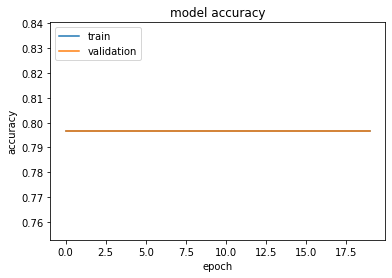

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


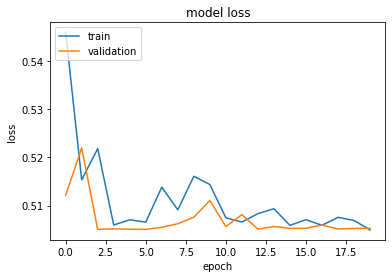

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()